## Неделя 1. Знакомство с данными и агрегация

Чтобы сдать задание, выполните следующую последовательность действий:  

1. Загрузите данные за май 2016 года.

2. Проведите фильтрацию: удалите поездки с

- нулевой длительностью  
- нулевым количеством пассажиров  
- нулевым расстоянием поездки по счётчику   
- координатами начала, не попадающими в прямоугольник Нью-Йорка  

Можно придумать ещё какие-то критерии для фильтрации данных; тем не менее, не стоит применять дополнительные фильтры: начиная с четвёртой недели вам предстоит сравнивать качество ваших прогнозов с качеством прогнозов других слушателей, и, чтобы это сравнение было корректным, нужно, чтобы данные у всех были предобработаны одинаково.

3. Агрегируйте данные за май 2016 года по часам и областям (можно использовать функцию stats.binned_statistic_2d, с которой вы сталкивались в заданиях четвёртого курса). Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу.

4. Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

5. Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

6. Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

In [1]:
# импорт модулей
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import datetime

In [2]:
# загрузка списка квадратов
regions = pd.read_csv('data/regions.csv', sep=';', header=0)
regions.head(2)

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896


### 1. Загрузите данные за май 2016 года

In [3]:
# загружаем данные за май 2016 года
df = pd.read_csv('data/yellow_tripdata_2016-05.csv')
df_len_before = df.shape[0]
df.shape

(11836853, 19)

In [4]:
# границы города
NY_west = min(regions.west)
NY_east = max(regions.east)
NY_south = min(regions.south)
NY_north = max(regions.north)

# координаты Empire State Building
ESB_lon = -73.985756
ESB_lat = 40.748306

### 2. Проведите фильтрацию  

In [5]:
# Фильтрация
# удаляем записи с нулевым временем поездки
df.drop(df[df.tpep_pickup_datetime == df.tpep_dropoff_datetime].index, inplace = True)
# удаляем записи с нулевым количеством пассажиров
df.drop(df[df.passenger_count == 0].index, inplace = True)
# удаляем записи с нулевым расстоянием 
df.drop(df[df.trip_distance == 0].index, inplace = True)
# удаляем записи не попадающие в заданные границы города
df.drop(list(
    df.index[
        (df.pickup_longitude < NY_west) | 
        (df.pickup_longitude > NY_east) | 
        (df.pickup_latitude < NY_south) | 
        (df.pickup_latitude > NY_north)]),
    inplace=True)

df.shape

(11626521, 19)

### 3.Агрегируйте данные за май 2016 года по часам и областям  

Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

In [6]:
# Преобразуем столбцы начала и окончания поездки в нужный формат времени
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

df.tpep_pickup_datetime = df.tpep_pickup_datetime.dt.floor(freq='h')
df.tpep_dropoff_datetime = df.tpep_dropoff_datetime.dt.floor(freq='h')

In [7]:
# определим пару вспомогательных функций
stepH = (NY_east - NY_west) / 50.0
stepV = (NY_north - NY_south) / 50.0

def CalcRegion(trip):
    if ((trip.pickup_longitude < NY_west) or (trip.pickup_longitude > NY_east) or 
            (trip.pickup_latitude > NY_north) or (trip.pickup_latitude < NY_south)):
        return 0
    horizontal_pos = int((trip.pickup_longitude - NY_west)/ stepH)
    vertical_pos = int((trip.pickup_latitude - NY_south)/ stepV)
    return 50 * horizontal_pos + vertical_pos + 1

def CalcRegionFromCords(lon, lat):
    if ((lon < NY_west) or (lon > NY_east) or (lat > NY_north) or (lat < NY_south)):
        return 0
    horizontal_pos = int((lon - NY_west)/ stepH)
    vertical_pos = int((lat - NY_south)/ stepV)
    return 50 * horizontal_pos + vertical_pos + 1

In [8]:
# создаем сводную таблицу времени, районов и количества поездок
x = np.linspace(NY_west, NY_east, 51)
y = np.linspace(NY_south, NY_north, 51)

periods = df.tpep_pickup_datetime.unique()

res = []
for i in range(len(periods)):
        time_samp = df[df.tpep_pickup_datetime == periods[i]]
        ret = stats.binned_statistic_2d(time_samp.pickup_longitude, time_samp.pickup_latitude, 
                                        None, statistic='count', bins=[x, y])
        res = res + (list(np.array([list([periods[i]])*2500, range(1,2501), ret.statistic.ravel()]).T))

## 4. Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

In [9]:
agg_table = pd.DataFrame(res, columns = ['date', 'start_region', 'trips_count'])
agg_table = agg_table.astype({'trips_count': 'int16'})
agg_table.head()

,date,start_region,trips_count
0,2016-05-01,1,0
1,2016-05-01,2,0
2,2016-05-01,3,0
3,2016-05-01,4,0
4,2016-05-01,5,0


## 5. Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building

In [10]:
# Определяем номер квадрата в котором находится Empire State Building
ESB_region = CalcRegionFromCords(ESB_lon, ESB_lat)
ESB_region

1231

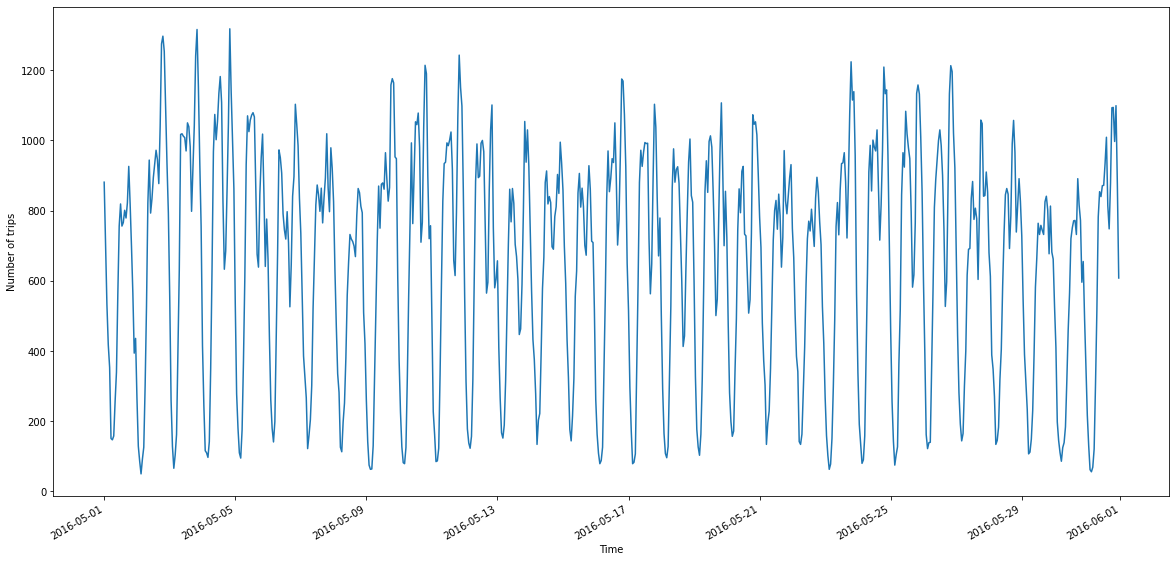

In [11]:
# Построим график
plt.figure(figsize=(20,10))
pd.Series(list(agg_table.trips_count[agg_table.start_region == ESB_region]), 
          index = list(agg_table.date[agg_table.start_region == ESB_region])).plot()
plt.ylabel('Number of trips');
plt.xlabel('Time');

In [ ]:
# Видим на графике ярко выраженную суточную и недельную сезонность

## 6. Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки. 


In [12]:
agg_table['trips_count'].value_counts().head()

0    1718238
1      39318
2      15074
3       8979
4       6125
Name: trips_count, dtype: int64